In [33]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from nbeats_pytorch.model import NBeatsNet

In [34]:
chunksize = 10000
reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)


In [35]:
df = pd.DataFrame()
for index, chunk in enumerate(reader):
        if index > 10:
            break
        df = pd.concat([df, chunk])

In [36]:
df.head(100)

,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
0,0,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,0,7.195093,7.195093
1,22430,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,60000,7.118115,7.118115
2,44840,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,120000,6.985224,6.985224
3,67235,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,180000,7.654883,7.654883
4,89612,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,240000,7.217251,7.217251
...,...,...,...,...,...
95,2144226,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5700000,7.159023,7.159023
96,2166891,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5760000,6.933686,6.933686
97,2189593,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5820000,6.938315,6.938315
98,2212252,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5880000,7.534233,7.534233


In [37]:
# 定义步长 K
TIME_STEP = 10


def split_array_by_step(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr)-k, k)]

# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')["HTTP_RT"].apply(
    lambda x: split_array_by_step(x, TIME_STEP+1)).reset_index()


In [38]:
combined_df = pd.DataFrame()

# 对于每个分组
for index, row in grouped_df.iterrows():
    if len(row["HTTP_RT"]) > 0:
        combined_df = pd.concat([combined_df, pd.DataFrame(
            np.stack([arr for arr in row["HTTP_RT"]], axis=0))])

print(combined_df.shape)

(9907, 11)


In [39]:
scaler = MinMaxScaler()
workload = scaler.fit_transform(combined_df)

In [40]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)

In [41]:
x_train, y_train = create_sequences(workload, TIME_STEP)

In [42]:
x_train=np.expand_dims(x_train, axis=2)
y_train=np.expand_dims(y_train, axis=1)
print(x_train.shape)
print(y_train.shape)

(9907, 10, 1)
(9907, 1)


In [43]:
train_size = int(len(x_train) * 0.8)
val_size = len(x_train) - train_size

x_train, x_val = x_train[0:train_size, :], x_train[train_size:len(x_train), :]
y_train, y_val = y_train[0:train_size], y_train[train_size:len(y_train)]


In [44]:
INPUT_DIM = 1
output_dim = 1
batch_size = 10 #每轮训练模型时，样本的数量
epochs = 50 #训练50轮次
hidden_size = 64
num_layers = 4

In [45]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [53]:
def train_model(train_x, train_y, model, epochs, batch_size, device):
    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            _, output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model


In [56]:
def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        _, y_pred = model(predict_x)
    return y_pred.cpu().numpy()


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NBeatsNet(stack_types=('generic', 'generic'),
                  nb_blocks_per_stack=3,
                  thetas_dim=(4, 4),
                  forecast_length=1,
                  backcast_length=10,
                  hidden_layer_units=hidden_size,
                  share_weights_in_stack=True)

model.to(device)

trained_model = train_model(x_train, y_train, model,
                            epochs, batch_size, device)


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=1, share_thetas=False) at @140610695571152
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=1, share_thetas=False) at @140610695571152
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=1, share_thetas=False) at @140610695571152
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=1, share_thetas=False) at @140610857046416
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=1, share_thetas=False) at @140610857046416
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=10, forecast_length=1, share_thetas=False) at @140610857046416
Epoch 1/50, Loss: 0.0035
Epoch 2/50, Loss: 0.0001
Epoch 3/50, Loss: 0.0001
Epoch 4/50, Loss: 0.0001
Epoch 5/50, Loss: 0.0001

In [57]:
def plot_predictions(y_val, y_pred):
    plt.figure(figsize=(12, 6))
    plt.ylim(0, 0.1)
    plt.plot(y_val, label="Actual Values", color='blue')
    plt.plot(y_pred, label="Predicted Values", color='red')
    plt.xlabel("Timestamp")
    plt.ylabel("Workload")
    plt.legend()
    plt.show()

y_pred = predict(trained_model, x_val, device)

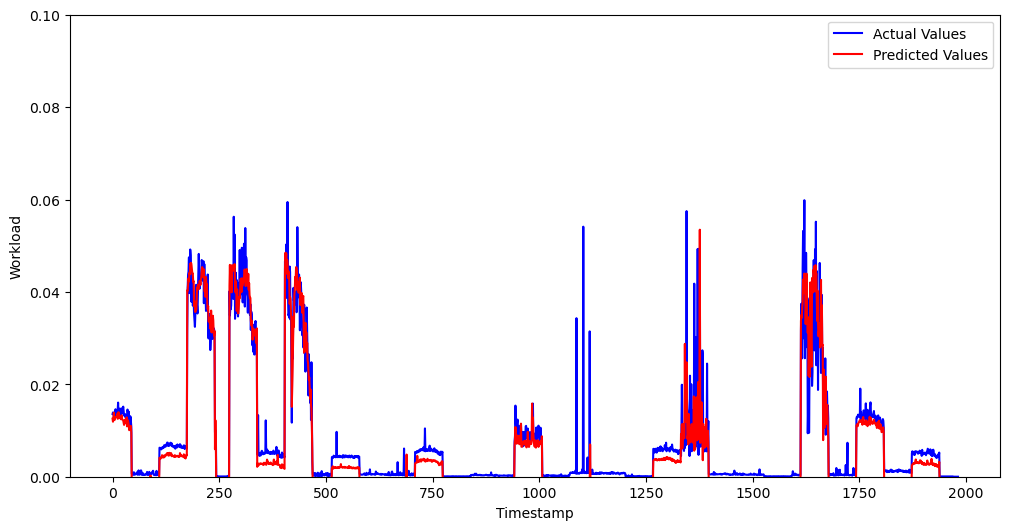

In [58]:
plot_predictions(y_val, y_pred)
# 保存模型
torch.save(model.state_dict(), "../../model/NBeats.pt")